In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import sqlalchemy
from sqlalchemy import create_engine
import os

In [54]:
def download_data():
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_file('muthuj7/weather-dataset', file_name='weatherHistory.csv')

In [55]:
database_path = 'C:/Users/waltt/Oma kansio/Opiskelu/Tietotekniikka/Data Analytics and Machine Learning/Final Project/Weather data/monthly_weather_data.db'


def extract_data():
    with zipfile.ZipFile('weatherHistory.csv.zip', 'r') as zipref:
        zipref.extractall()
    df = pd.read_csv('weatherHistory.csv')
    return df

def transform_data(df):
    # Step 2: Transform Data
    df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

    # Daily averages
    daily_averages = df.groupby(df['Formatted Date'].dt.date).agg({
        'Temperature (C)': 'mean',
        'Humidity': 'mean', 
    }).reset_index()
    
    # Monthly mode for precipitation type
    monthly_mode = df.groupby(df['Formatted Date'].dt.to_period("M"))['Precip Type'].agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else None
    ).reset_index()
    monthly_mode.columns = ['Month', 'Mode']
    
    # New feature for Wind Strength
    wind_strength_bins = [0, 1.5, 3.3, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4, 28.4, 32.6, float('inf')]
    wind_strength_labels = ['Calm', 'Light Air', 'Light Breeze', 'Gentle Breeze', 'Moderate Breeze', 
                            'Fresh Breeze', 'Strong Breeze', 'Near Gale', 'Gale', 'Strong Gale', 
                            'Storm', 'Violent Storm']
    df['Wind Strength Category'] = pd.cut(
        df['Wind Speed (km/h)'], bins=wind_strength_bins, labels=wind_strength_labels, right=False
    )

    # Monthly averages for temperature and humidity
    monthly_averages = df.groupby(df['Formatted Date'].dt.to_period("M")).agg({
        'Temperature (C)': 'mean',
        'Humidity': 'mean', 
    }).reset_index()
    
    # Creating a monthly summary DataFrame
    df_monthly = pd.DataFrame()
    df_monthly['Date'] = monthly_averages['Formatted Date']
    df_monthly['Average Temperature (C)'] = monthly_averages['Temperature (C)']
    df_monthly['Average Humidity'] = monthly_averages['Humidity']
    df_monthly['Mode'] = monthly_mode['Mode']

    return df_monthly, df
        
def load_data_to_db(df, db_uri, table_name):
    engine = create_engine(db_uri)
    df['Date'] = df['Date'].astype(str)
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)
        
def df_to_csv(df):
    df.to_csv("Monthly data.csv", encoding='utf-8', index=False)
    
def ensure_database_directory(database_path):
    database_dir = os.path.dirname(database_path)
    if not os.path.exists(database_dir):
        os.makedirs(database_dir)
        

def etl_process():
    ensure_database_directory(database_path)
    # Download and extract data
    download_data()
    df = extract_data()

    # Transform data
    transformed_df, weather_data = transform_data(df)

    # Save transformed data to a CSV file
    transformed_df.to_csv("Monthly_data.csv", encoding='utf-8', index=False)
        
    # Load data to a database
    load_data_to_db(transformed_df, f'sqlite:///{database_path}', 'monthly_weather_data')
        
    return transformed_df, weather_data
        

monthly_data, weather_data = etl_process()

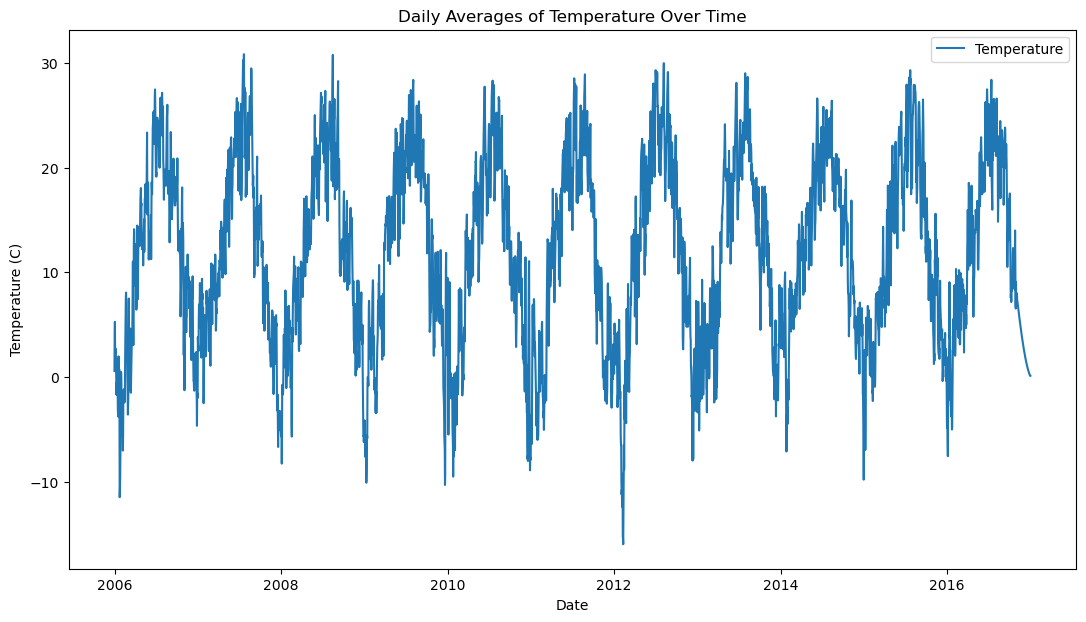

In [56]:
weather_data['Formatted Date'] = pd.to_datetime(weather_data['Formatted Date'], utc=True)

daily_averages = weather_data.groupby(weather_data['Formatted Date'].dt.date).agg({
    'Temperature (C)': 'mean',
}).reset_index()

plt.figure(figsize=(13, 7))
sns.lineplot(x=daily_averages['Formatted Date'], y=daily_averages['Temperature (C)'], label='Temperature')
plt.title('Daily Averages of Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.show()

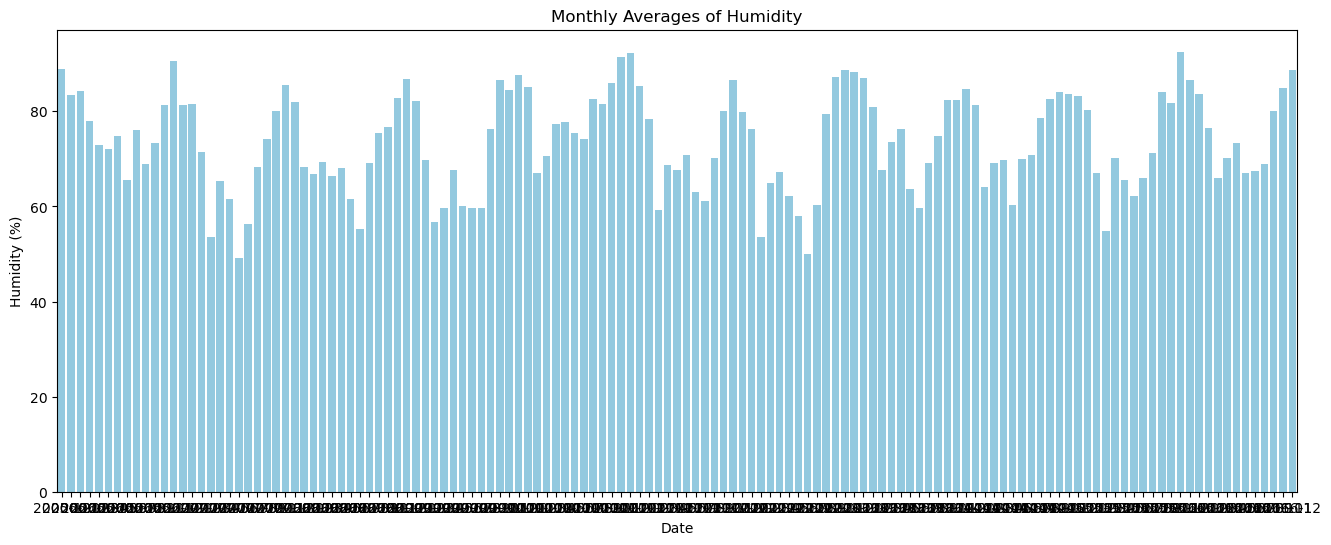

In [59]:
plt.figure(figsize=(16, 6))
sns.barplot(x=monthly_averages['Date'], y=monthly_averages['Average Humidity']*100, label='Humidity', color='skyblue')
plt.title('Monthly Averages of Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.show()

In [58]:
# Ensuring the 'Date' column is in datetime format first
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'], errors='coerce')

# Converting to Period type (Monthly period)
monthly_data['Date'] = monthly_data['Date'].dt.to_period('M')

# Aggregating monthly values (without 'std')
monthly_aggregates = (
    monthly_averages.groupby('Date')['Average Temperature (C)']
    .agg(['min', 'max'])  # Only min and max, no std
    .reset_index()
)

# Rounding values to the specified decimal precision
monthly_aggregates['min'] = monthly_aggregates['min'].round(num_decimals)
monthly_aggregates['max'] = monthly_aggregates['max'].round(num_decimals)

# Monthly min max
monthly_min_max = (
    weather_data.groupby(weather_data['Formatted Date'].dt.to_period("M"))['Temperature (C)']
    .agg(['min', 'max'])
    .reset_index()
)
monthly_min_max['min'] = monthly_min_max['min'].round(num_decimals)
monthly_min_max['max'] = monthly_min_max['max'].round(num_decimals)

# Merging monthly_data with monthly_min_max
combined_data = pd.merge(
    monthly_data, 
    monthly_min_max, 
    left_on='Date', 
    right_on='Formatted Date', 
    how='left'
)

# Drop redundant columns and finalize formatting
combined_data = combined_data.drop('Formatted Date', axis=1, errors='ignore')

combined_data

,Date,Average Temperature (C),Average Humidity,Mode,min,max
0,2005-12,0.577778,0.890000,rain,0.5778,0.5778
1,2006-01,-1.677942,0.834610,snow,-14.0889,7.5056
2,2006-02,-0.065394,0.843467,snow,-13.9278,14.0833
3,2006-03,4.559274,0.778737,rain,-10.1000,21.1833
4,2006-04,12.635031,0.728625,rain,0.9556,25.0444
...,...,...,...,...,...,...
128,2016-08,21.420296,0.674046,rain,8.9889,32.1944
129,2016-09,18.467924,0.688833,rain,5.9556,32.0000
130,2016-10,9.893242,0.799906,rain,0.9944,25.0444
131,2016-11,5.282662,0.848472,rain,0.5222,12.6333
